In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# importing spark session
from pyspark.sql import SparkSession

# data visualization modules
import matplotlib.pyplot as plt
import plotly.express as px

# pandas module
import pandas as pd

# pyspark SQL functions
from pyspark.sql.functions import col, when, count, udf

# pyspark data preprocessing modules
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, StandardScaler

# pyspark data modeling and model evaluation modules
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


# Building our Spark Session

In [3]:
spark = SparkSession.builder.appName("Loan_Prediction").getOrCreate()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/10 07:37:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load our data

In [5]:
train = spark.read.format('csv').option('inferSchema', True).option('header', True).load('/kaggle/input/playground-series-s5e11/train.csv')
test = spark.read.format('csv').option('inferSchema', True).option('header', True).load('/kaggle/input/playground-series-s5e11/test.csv')

In [13]:
train.show(5)

+---+-------------+--------------------+------------+-----------+-------------+------+--------------+---------------+-----------------+------------------+--------------+--------------+
| id|annual_income|debt_to_income_ratio|credit_score|loan_amount|interest_rate|gender|marital_status|education_level|employment_status|      loan_purpose|grade_subgrade|loan_paid_back|
+---+-------------+--------------------+------------+-----------+-------------+------+--------------+---------------+-----------------+------------------+--------------+--------------+
|  0|     29367.99|               0.084|         736|    2528.42|        13.67|Female|        Single|    High School|    Self-employed|             Other|            C3|           1.0|
|  1|     22108.02|               0.166|         636|     4593.1|        12.92|  Male|       Married|       Master's|         Employed|Debt consolidation|            D3|           0.0|
|  2|      49566.2|               0.097|         694|   17005.15|         9

In [12]:
print("Train shape:", train.count(), len(train.columns)) # Number of rows and columns

Train shape: 593994 13


# Exploratory Data Analysis

In [14]:
train.dtypes

[('id', 'int'),
 ('annual_income', 'double'),
 ('debt_to_income_ratio', 'double'),
 ('credit_score', 'int'),
 ('loan_amount', 'double'),
 ('interest_rate', 'double'),
 ('gender', 'string'),
 ('marital_status', 'string'),
 ('education_level', 'string'),
 ('employment_status', 'string'),
 ('loan_purpose', 'string'),
 ('grade_subgrade', 'string'),
 ('loan_paid_back', 'double')]

### Splitting the dataset into numerical and categorical columns

In [15]:
num_cols = [name for name, typ in test.dtypes if typ == 'double']
cat_cols = [name for name, typ in test.dtypes if typ == 'string']
num_cols

['annual_income', 'debt_to_income_ratio', 'loan_amount', 'interest_rate']

In [16]:
# show numerical cols in our train dataset
train.select(num_cols).show(5)

+-------------+--------------------+-----------+-------------+
|annual_income|debt_to_income_ratio|loan_amount|interest_rate|
+-------------+--------------------+-----------+-------------+
|     29367.99|               0.084|    2528.42|        13.67|
|     22108.02|               0.166|     4593.1|        12.92|
|      49566.2|               0.097|   17005.15|         9.76|
|     46858.25|               0.065|    4682.48|         16.1|
|      25496.7|               0.053|   12184.43|        10.21|
+-------------+--------------------+-----------+-------------+
only showing top 5 rows



In [17]:
# Convert the train into pandas df for visualization
df = train.select(num_cols).toPandas()
df.head()

,annual_income,debt_to_income_ratio,loan_amount,interest_rate
0,29367.99,0.084,2528.42,13.67
1,22108.02,0.166,4593.10,12.92
2,49566.20,0.097,17005.15,9.76
3,46858.25,0.065,4682.48,16.10
4,25496.70,0.053,12184.43,10.21


## Histogram

### <code>Histogram</code> are useful in identifying outliers in numerical columns. The distribution of values help us identify unusual values and patterns that require investigation

In [18]:
import plotly as px

/tmp/ipykernel_55/1243126643.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax=ax)


array([[<Axes: title={'center': 'annual_income'}>,
        <Axes: title={'center': 'debt_to_income_ratio'}>],
       [<Axes: title={'center': 'loan_amount'}>,
        <Axes: title={'center': 'interest_rate'}>]], dtype=object)

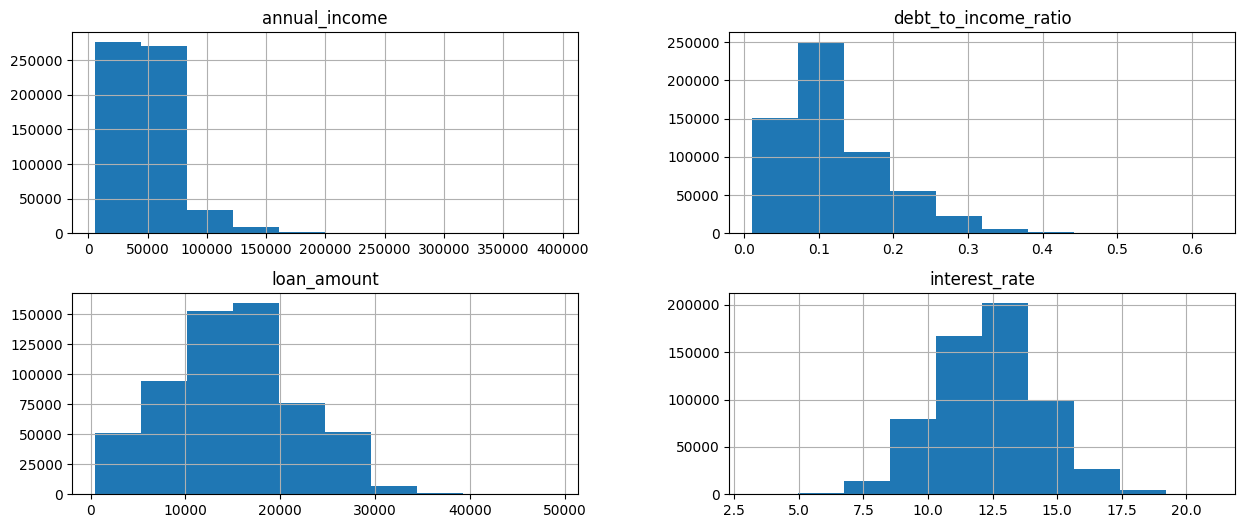

In [22]:
fig = plt.figure(figsize=(15, 6))
ax = fig.gca()
df.hist(ax=ax)

### As we can see from hist charts of <code>annual_income</code> and <code>debt_to_income_ratio</code> that are so stretched out. To investigate further, we need to look at descriptive stats for both columns and find the difference between mean and maximum value.

## Box Plots

<Axes: >

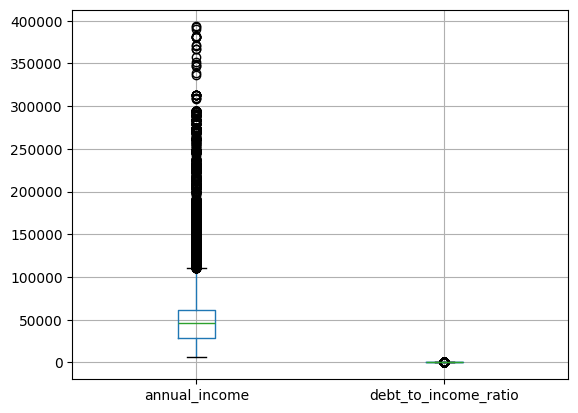

In [35]:
df[['annual_income', 'debt_to_income_ratio']].boxplot()

## Outliers
- Find the columns with outliers

In [23]:
df[['annual_income', 'debt_to_income_ratio']].describe()

,annual_income,debt_to_income_ratio
count,593994.000000,593994.000000
mean,48212.202976,0.120696
std,26711.942078,0.068573
min,6002.430000,0.011000
25%,27934.400000,0.072000
50%,46557.680000,0.096000
75%,60981.320000,0.156000
max,393381.740000,0.627000


In [31]:
train.select('*').where(train.annual_income > 300000).count()

31

## Missing values
- Find the missing values

In [32]:
for column in train.columns:
  train.select(count(when(col(column).isNull(), column)).alias(column)).show()

+---+
| id|
+---+
|  0|
+---+



+-------------+
|annual_income|
+-------------+
|            0|
+-------------+



+--------------------+
|debt_to_income_ratio|
+--------------------+
|                   0|
+--------------------+

+------------+
|credit_score|
+------------+
|           0|
+------------+



+-----------+
|loan_amount|
+-----------+
|          0|
+-----------+



+-------------+
|interest_rate|
+-------------+
|            0|
+-------------+

+------+
|gender|
+------+
|     0|
+------+



+--------------+
|marital_status|
+--------------+
|             0|
+--------------+

+---------------+
|education_level|
+---------------+
|              0|
+---------------+



+-----------------+
|employment_status|
+-----------------+
|                0|
+-----------------+



+------------+
|loan_purpose|
+------------+
|           0|
+------------+



+--------------+
|grade_subgrade|
+--------------+
|             0|
+--------------+

+--------------+
|loan_paid_back|
+--------------+
|             0|
+--------------+



### We do not have any missing values